In [1]:
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import scanpy as sc
import anndata
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import seaborn as sns
from itertools import chain
#only needed  in development
import importlib # use like this: importlib.reload(typing_comparison.utils)

In [4]:
sys.path.insert(1, '/secure/projects/HTAPP_MBC/src/spatial')
from spatial_utils import *

In [5]:
sample="HTAPP-878-SMP-7149"

In [6]:
#These identifiers are set as defaults in many functions. If names are changed, this has to be adapted when calling the functions.
ct_column='cell_type'
sm_methods=["slide_seq","merfish","merfish_bin","codex"] #spatial mathod names are hard-coded for now because some methods need special treatments. Can be fixed by giving eatch method it's own variable.
sc_method="scRNAseq"
he_method="HE_highres"
all_methods=[sc_method,*sm_methods,he_method]
all_methods

['scRNAseq', 'slide_seq', 'merfish', 'merfish_bin', 'codex', 'HE_highres']

In [7]:
out_dir=out_dir_base+sample
os.makedirs(out_dir, exist_ok=True)

## Align and prep data

In [8]:
#get the data without processing (Filter: min_genes=30 min_cells=3 but further reduce low count obs if more than 35%)
adatas=get_and_process_data(sample,data_dir,out_dir,methods=all_methods,process=False)

Creating scRNAseq


... storing 'replicate' as categorical
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Creating slide_seq
Creating merfish
Creating merfish_bin
Creating codex
Creating HE_highres
Creating HE_highres


In [9]:
#select colors for single cell
sel_colors=colors[colors.index.isin(adatas[sc_method].obs[ct_column])]
adatas[sc_method].obs[ct_column]=pd.Categorical(adatas[sc_method].obs[ct_column], categories=sel_colors.index,ordered=True)
adatas[sc_method].uns[ct_column+"_colors"]=list(sel_colors.values)

In [28]:
#Note: the pre-applied HE scaling factor is 0.4 per default. Take this into account to align to a differently scaled HE. 

registration=pd.DataFrame(index=[i for i in list(replicate_splitter(adatas).index) if not (sc_method in i)] , 
                          columns=["crop_left","crop_right","crop_top","crop_bottom","scale","shift_x","shift_y","degrees"])
#HE 1
registration.loc["HE 1","crop_left"]=-200
registration.loc["HE 1","crop_right"]=0
registration.loc["HE 1","crop_top"]=0
registration.loc["HE 1","crop_bottom"]=-450
registration.loc["HE 1","scale"]=0.6905#0.67
registration.loc["HE 1","degrees"]=0.5

#HE 2
registration.loc["HE 2","crop_left"]=350
registration.loc["HE 2","crop_right"]=1000
registration.loc["HE 2","crop_top"]=200
registration.loc["HE 2","crop_bottom"]=250
registration.loc["HE 2","scale"]=0.6905#0.67
registration.loc["HE 2","degrees"]=-13.5

#Annotation HE 1
registration.loc["HE 1 annot","crop_left"]=0
registration.loc["HE 1 annot","crop_right"]=0
registration.loc["HE 1 annot","crop_top"]=0
registration.loc["HE 1 annot","crop_bottom"]=0
registration.loc["HE 1 annot","scale"]=registration.loc["HE 1","scale"]/0.67
registration.loc["HE 1 annot","degrees"]=0


#Annotation HE 2
registration.loc["HE 2 annot","crop_left"]=0
registration.loc["HE 2 annot","crop_right"]=0
registration.loc["HE 2 annot","crop_top"]=0
registration.loc["HE 2 annot","crop_bottom"]=0
registration.loc["HE 2 annot","scale"]=registration.loc["HE 2","scale"]/0.67
registration.loc["HE 2 annot","degrees"]=0

#slide_seq 1
registration.loc["slide_seq 1","shift_x"]=-40
registration.loc["slide_seq 1","shift_y"]=1450
registration.loc["slide_seq 1","degrees"]=59

#slide_seq 2
registration.loc["slide_seq 2","shift_x"]=270
registration.loc["slide_seq 2","shift_y"]=1350
registration.loc["slide_seq 2","degrees"]=-131

#merfish 2
registration.loc["merfish 2","shift_x"]=-940
registration.loc["merfish 2","shift_y"]=1160
registration.loc["merfish 2","degrees"]=85.5

#merfish_bin 2
registration.loc["merfish_bin 2","shift_x"]=-1080
registration.loc["merfish_bin 2","shift_y"]=1240
registration.loc["merfish_bin 2","degrees"]=86

#codex 2
registration.loc["codex 2","shift_x"]=360
registration.loc["codex 2","shift_y"]=190
registration.loc["codex 2","degrees"]=3

reg_file=out_dir+"/"+sample+"_registration.csv"
if os.path.isfile(reg_file)&False:
    print("Reading registation.")
    registration=pd.read_csv(reg_file,index_col=0)
else:
    print("Writing registration.")
    registration.to_csv(reg_file)

Writing registration.


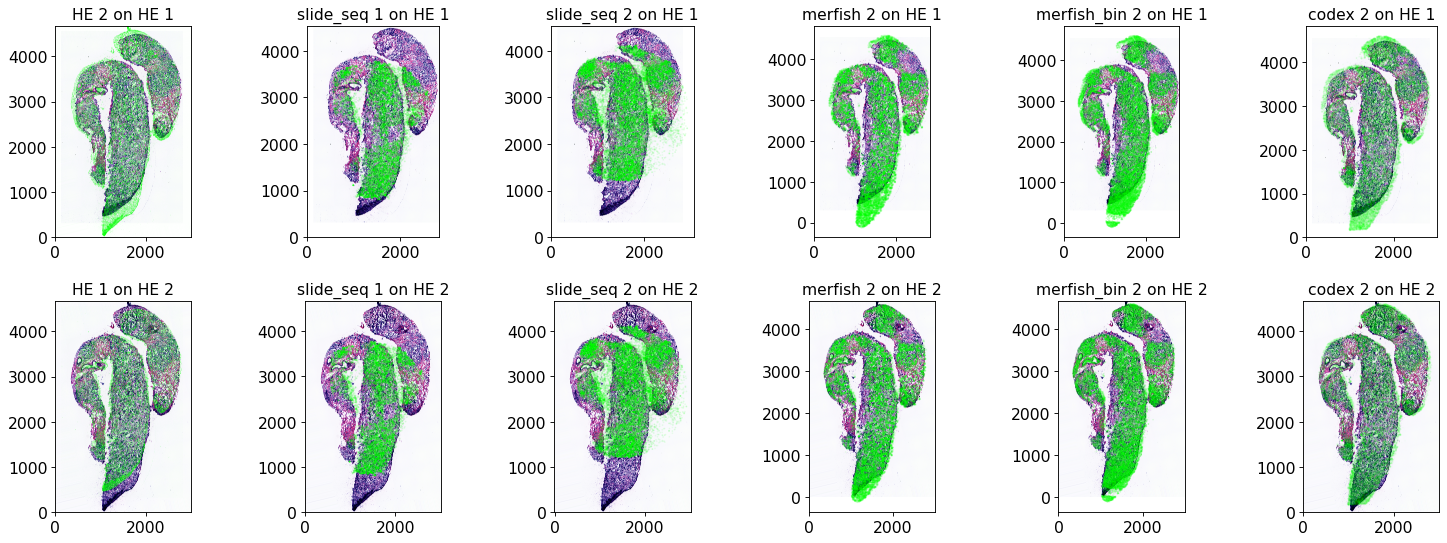

In [30]:
aligner(adatas,img_idx="HE 1",img_idx2="HE 2",dat_idxs=["slide_seq 1","slide_seq 2","merfish 2","merfish_bin 2","codex 2"],registration=registration,dot_sizes=[0.5,0.5,0.9,0.05,0.5],figsize=(24,8),adjust=True,change=True)

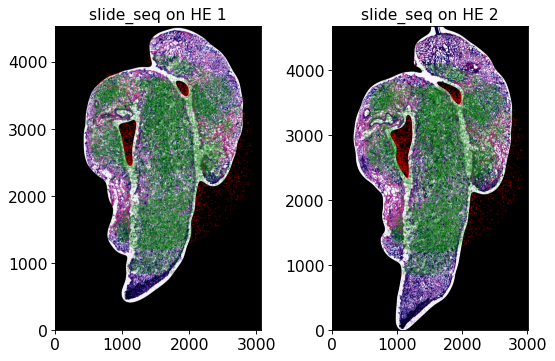

In [31]:
create_mask(adatas, ["HE 1","HE 2"],dat_idxs=["slide_seq"],figsize=(8,5),dot_sizes=[0.3],s=70,t=0.8)

In [63]:
def add_annotations(adatas,sample,dat_idxs,registration):
    for replicate in [1,2]:
        replicate=str(replicate)
        sample_ID=sample + "_HE_" + replicate
        img=anno_dir+'/'+sample+'/**/'+ sample_ID + "_[a-zA-Z]*_Fill.png"
        source_glob=glob.glob(img, recursive=True)
        for anno_file in source_glob:
            anno_name=anno_file.split("_")[-2]
            print(anno_name)
            img=mpimg.imread(anno_file)
            
            #adjust annotation HE
            img_idx="HE "+replicate+" annot"
            img = transform.rotate(img,angle=registration.loc[img_idx,"degrees"],resize=True,mode="edge")
            img=scale(img,rat=registration.loc[img_idx,"scale"],
                      crop_x=(registration.loc[img_idx,"crop_left"],registration.loc[img_idx,"crop_right"]),
                      crop_y=(registration.loc[img_idx,"crop_bottom"],registration.loc[img_idx,"crop_top"]))

            blur = img[:,:,3]
            mask = blur > 0
            
            for j,dat_idx in enumerate(dat_idxs):
                mask.shape
                ijs = adatas[dat_idx].obs[['x','y']].astype(int).to_numpy()
                in_mask = ((ijs < mask.T.shape) & (ijs >= 0)).all(axis=1)
                adatas[dat_idx].obs[anno_name+"_"+replicate]=in_mask
                adatas[dat_idx].obs.loc[in_mask,anno_name+"_"+replicate]=mask[adatas[dat_idx].obs.y.astype(int)[in_mask],adatas[dat_idx].obs.x.astype(int)[in_mask]]

In [64]:
add_annotations(adatas,sample,dat_idxs=["slide_seq","merfish","merfish_bin","codex"],registration=registration)

Tumor
ImmuneCells
Unidentifiable
Fibrosis
Vasculature
Necrosis
Unidentifiable
Necrosis
ImmuneCells
Tumor
Vasculature
Fibrosis


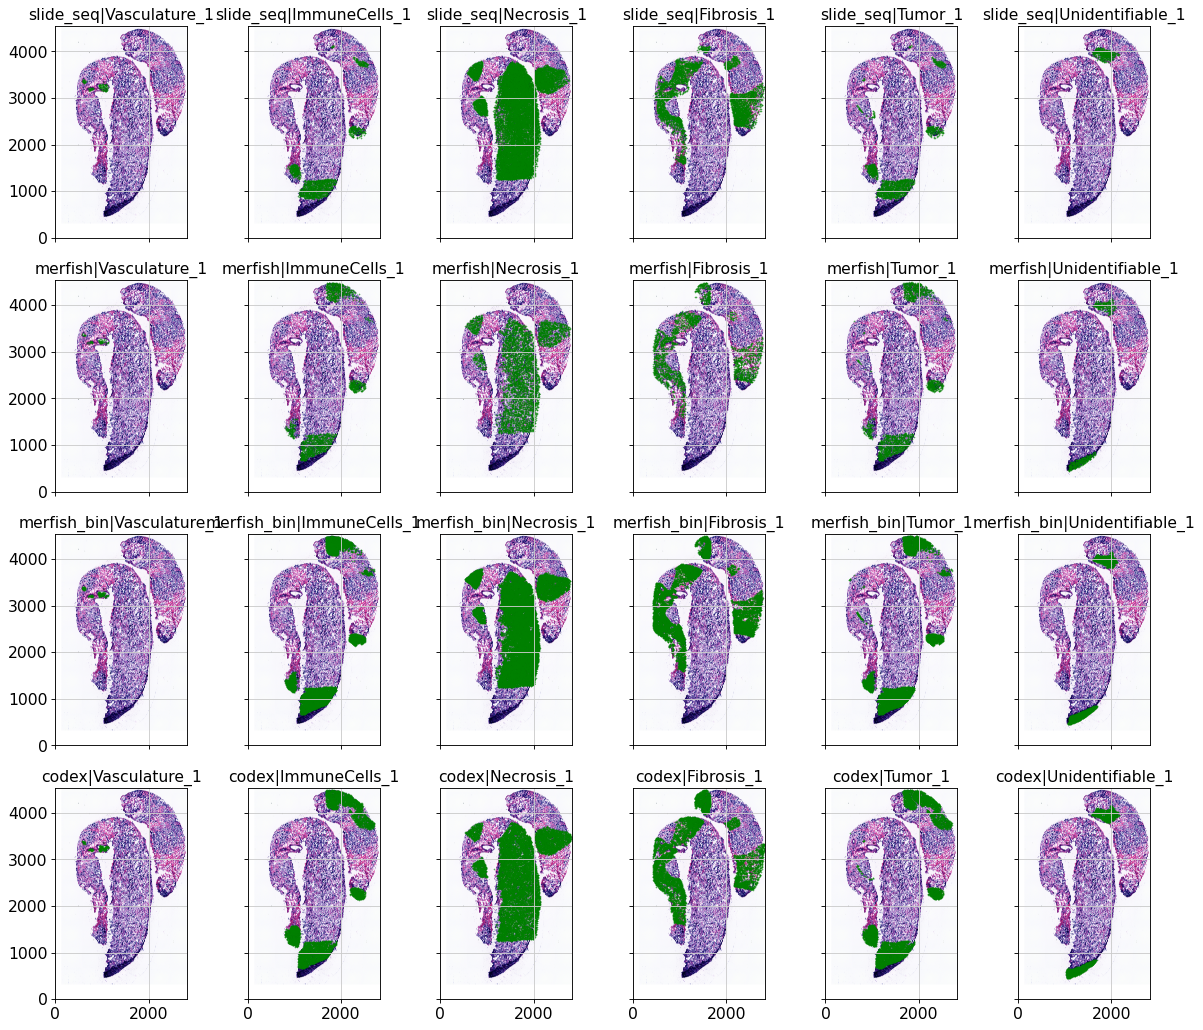

In [65]:
plot_annnotation(adatas,dat_idxs=["slide_seq","merfish","merfish_bin","codex"],annots=["Vasculature_1","ImmuneCells_1","Necrosis_1","Fibrosis_1","Tumor_1","Unidentifiable_1"],HE="HE 1",figsize=[18,16])

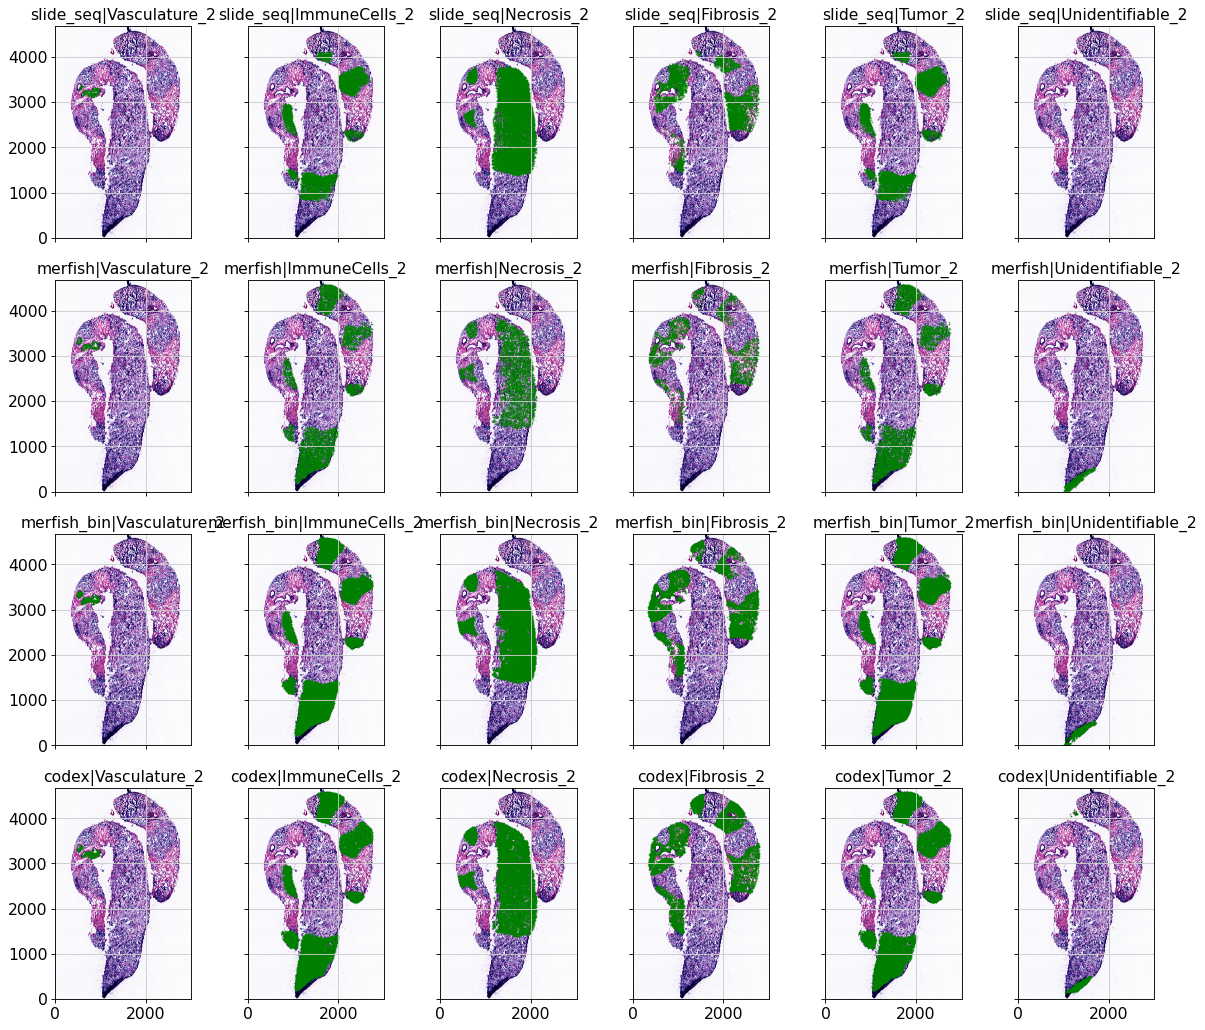

In [66]:
plot_annnotation(adatas,dat_idxs=["slide_seq","merfish","merfish_bin","codex"],annots=["Vasculature_2","ImmuneCells_2","Necrosis_2","Fibrosis_2","Tumor_2","Unidentifiable_2"],HE="HE 2",figsize=[18,16])

In [67]:
adatas=update_processed_adatas(adatas,sample,out_dir,all_methods,overwrite=True,process=True)

Processing scRNAseq
No HE masks found. Not trimming data.


Trying to set attribute `.obs` of view, copying.


Processing slide_seq
Processing merfish
No HE masks found. Not trimming data.
Processing merfish_bin
No HE masks found. Not trimming data.
Processing codex
No HE masks found. Not trimming data.
Normalization turned off.


## Load the processed data

In [68]:
adatas=get_and_process_data(sample,data_dir,out_dir,methods=all_methods)

reading  scRNAseq  from buffer
reading  slide_seq  from buffer
reading  merfish  from buffer
reading  merfish_bin  from buffer
reading  codex  from buffer
Loading processed HE_highres
Loading processed HE_highres


## Look at the data

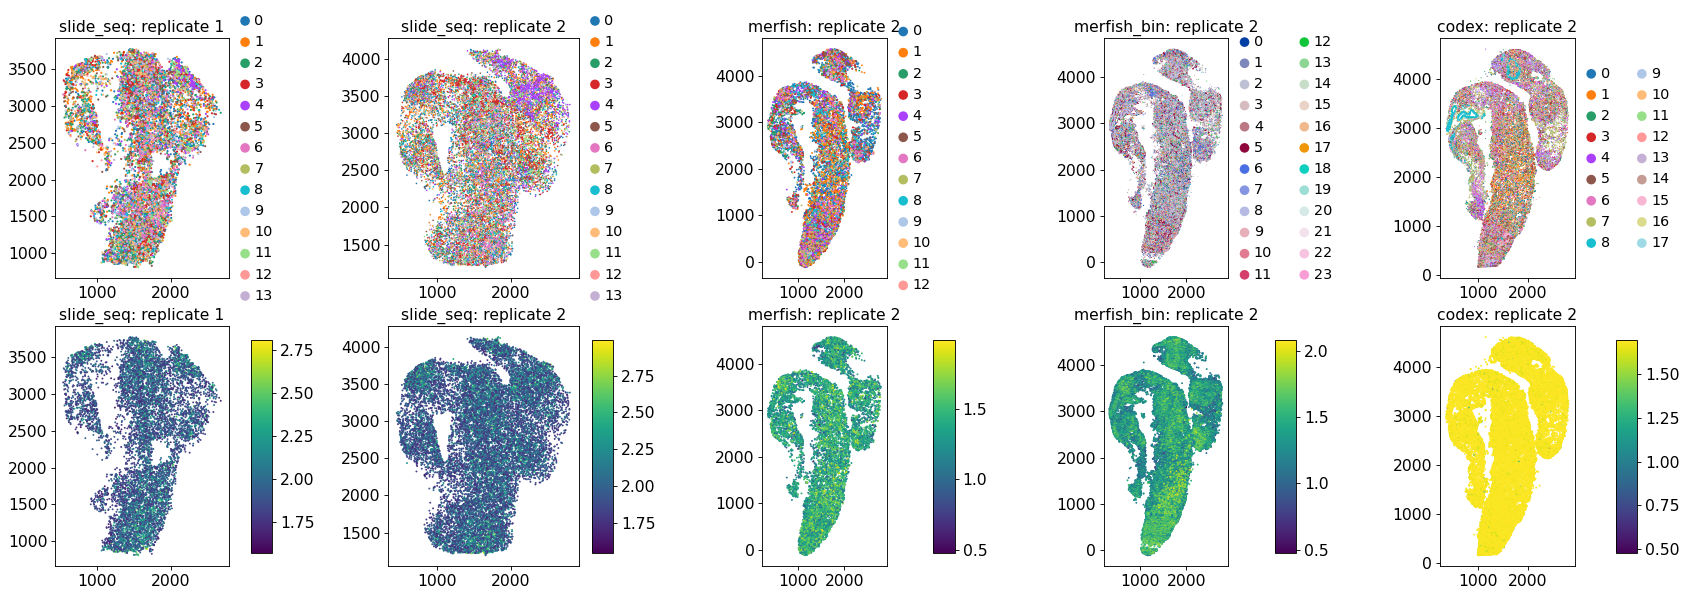

In [78]:
plot_spatial_obs(adatas,sm_methods,axsize=(4,3),wspace=0,x_shifts=[0,-0.03])

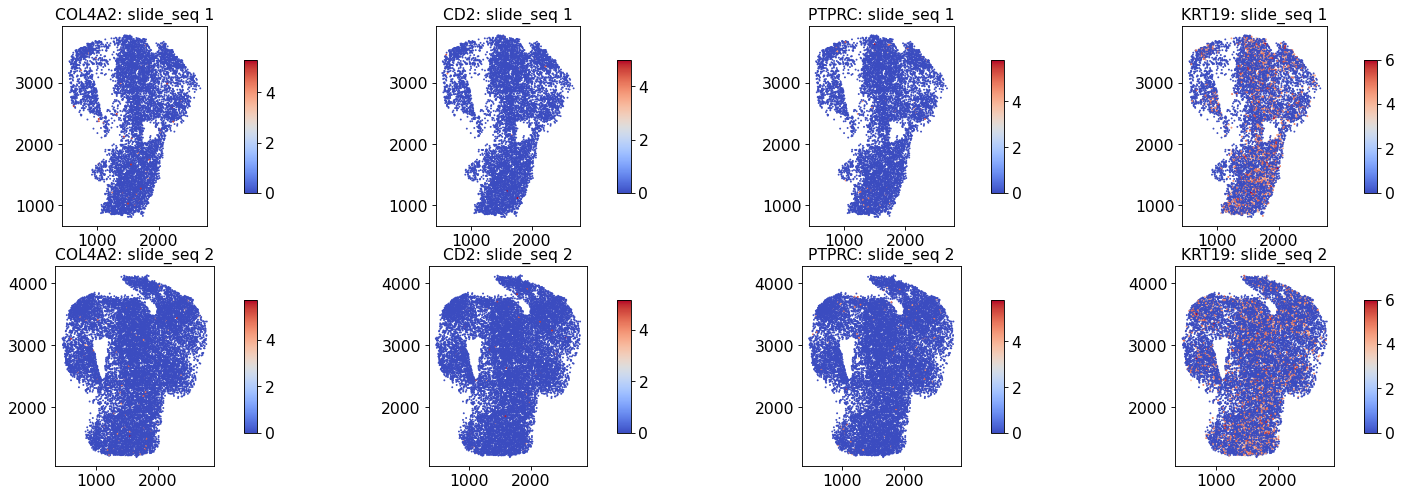

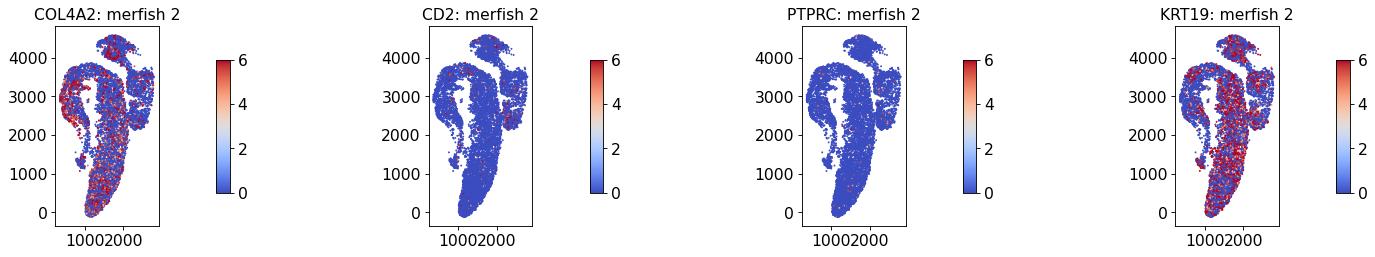

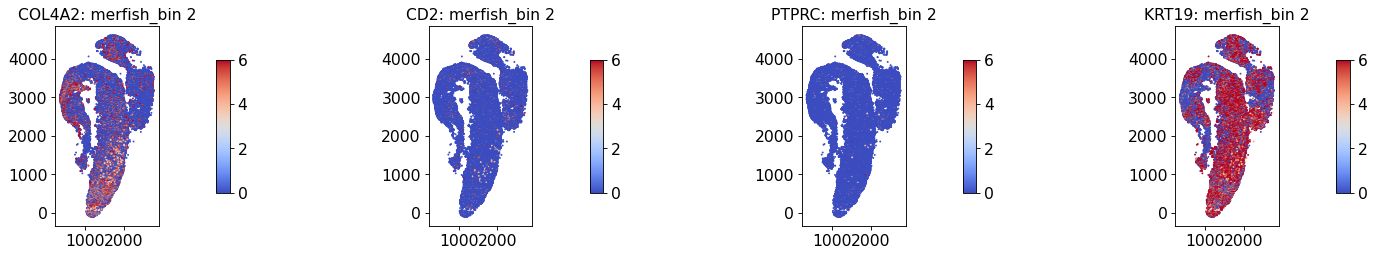

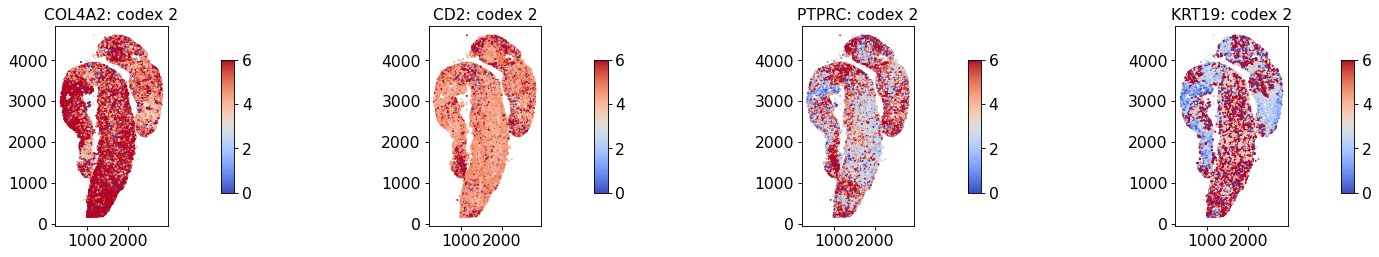

In [70]:
plot_spatial_genes(adatas,methods=sm_methods,genes = ["COL4A2","CD2","PTPRC","KRT19"],axsize=(2.5,2.5))

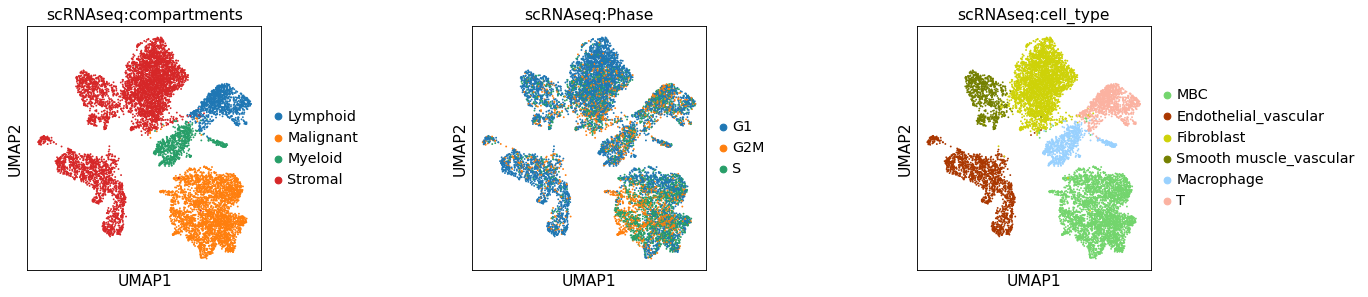

In [71]:
plot_variable_individual(adatas,method_vars=[("scRNAseq","compartments"),("scRNAseq","Phase"),("scRNAseq","cell_type")])

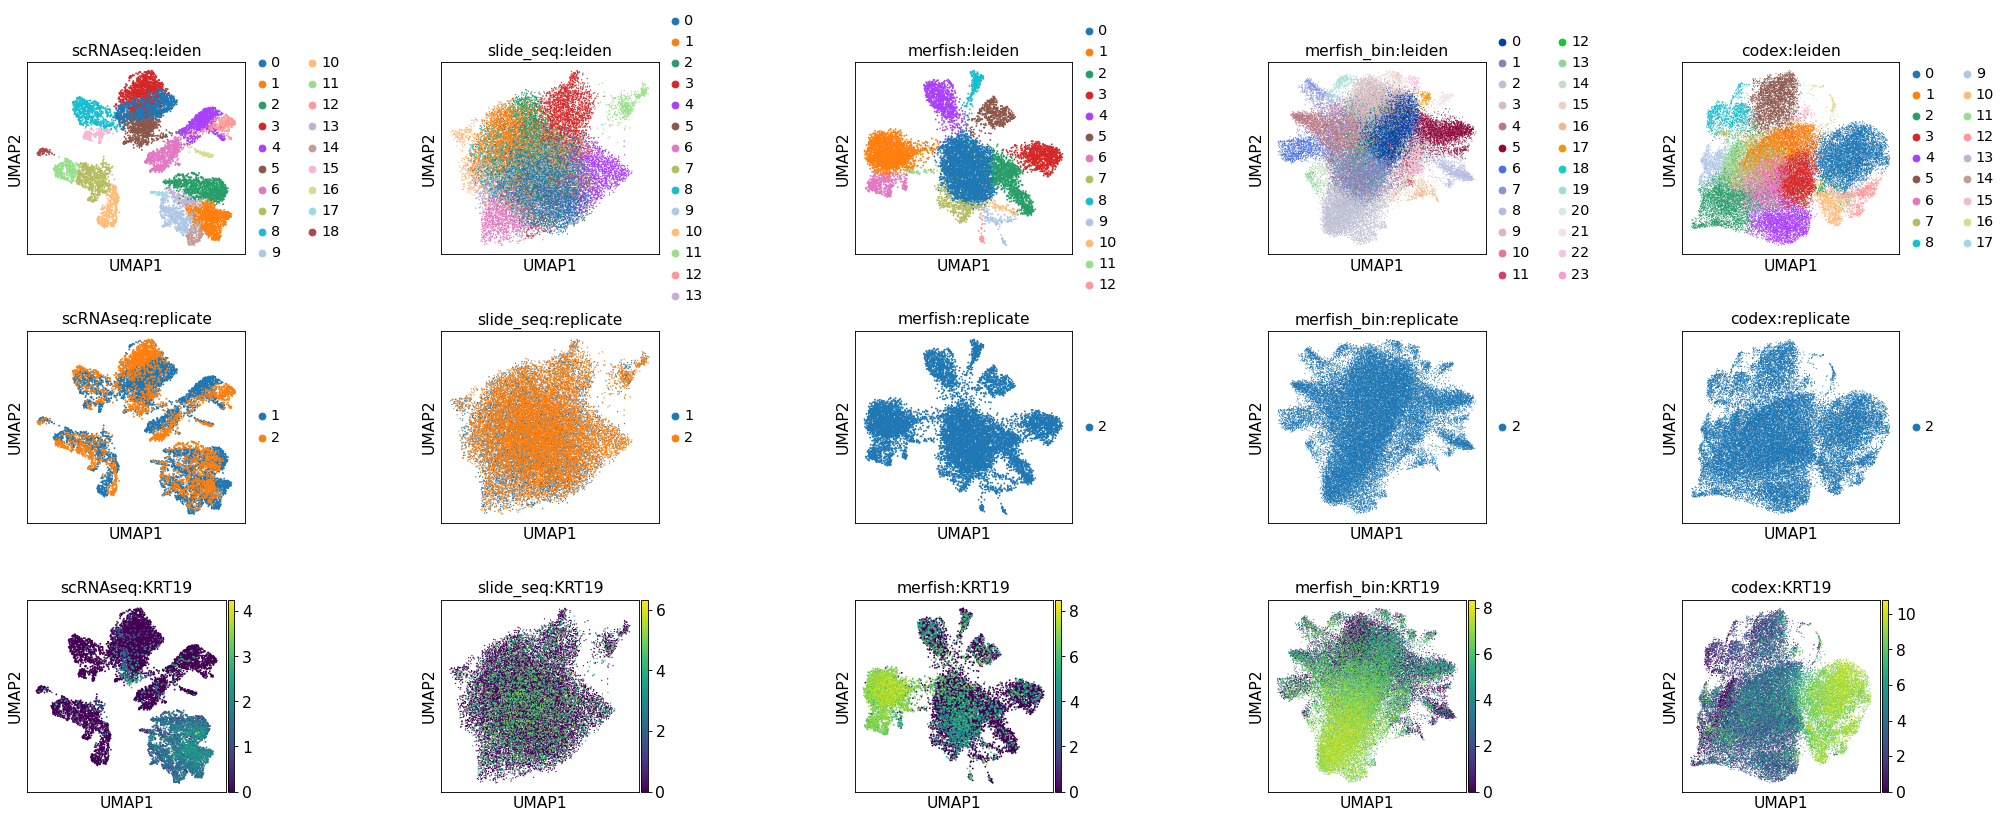

In [72]:
plot_variable_grid(adatas,methods=[sc_method,*sm_methods],variables=['leiden','replicate','KRT19'])

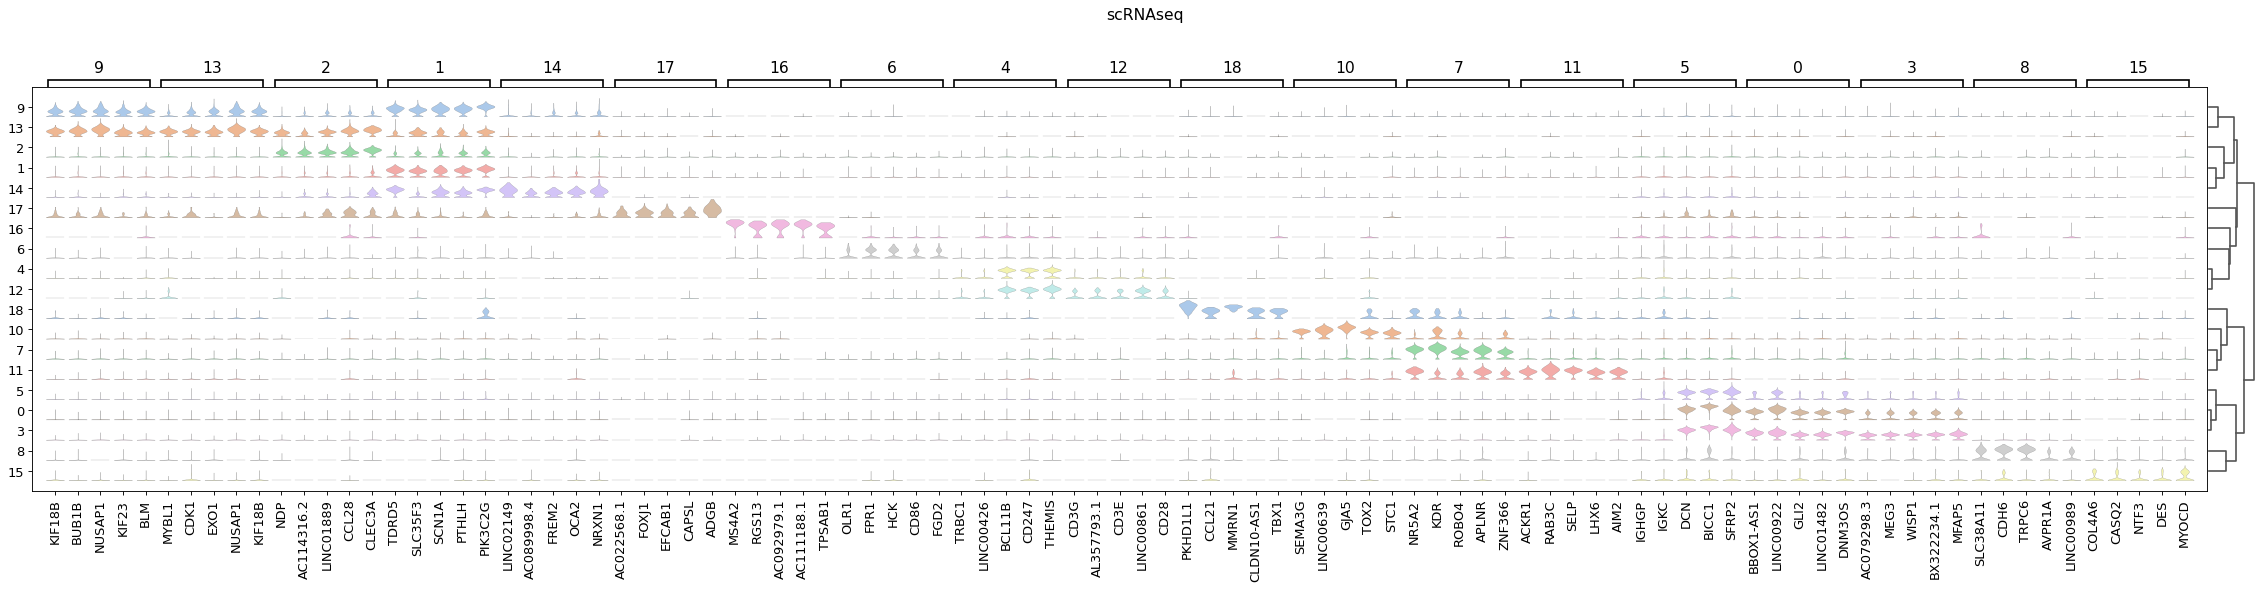

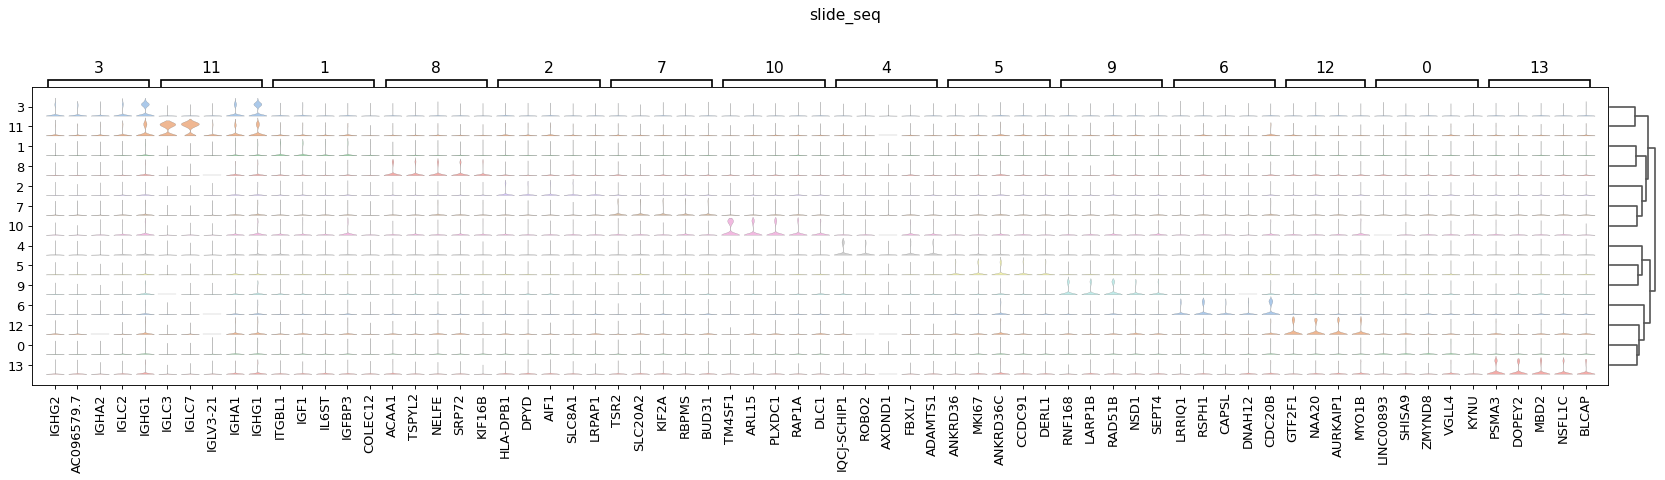

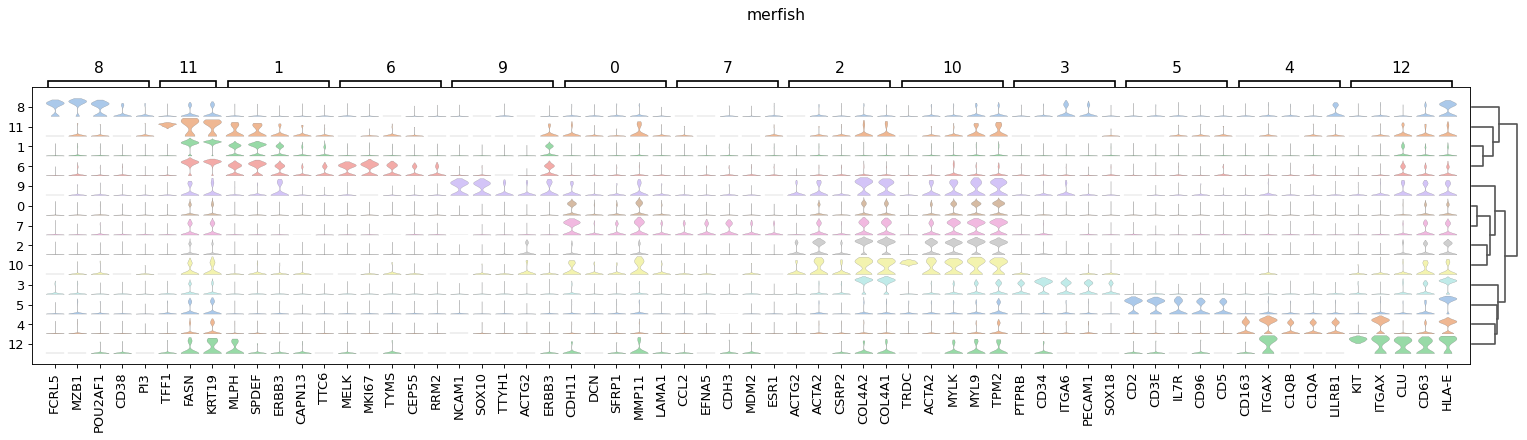

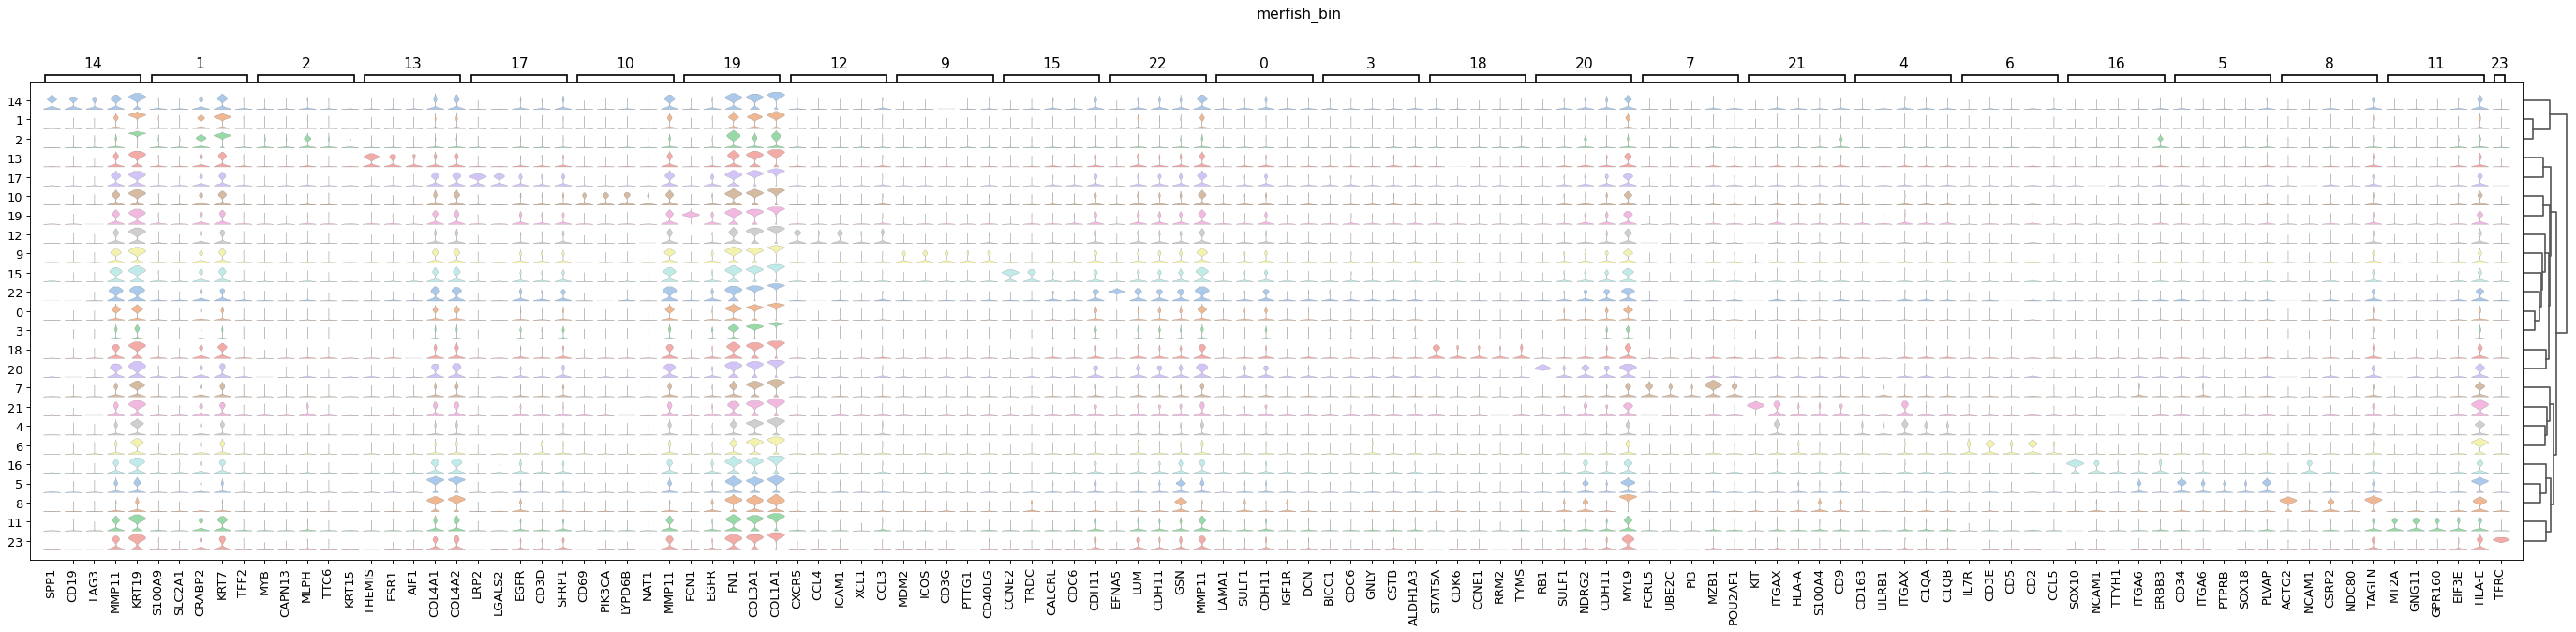

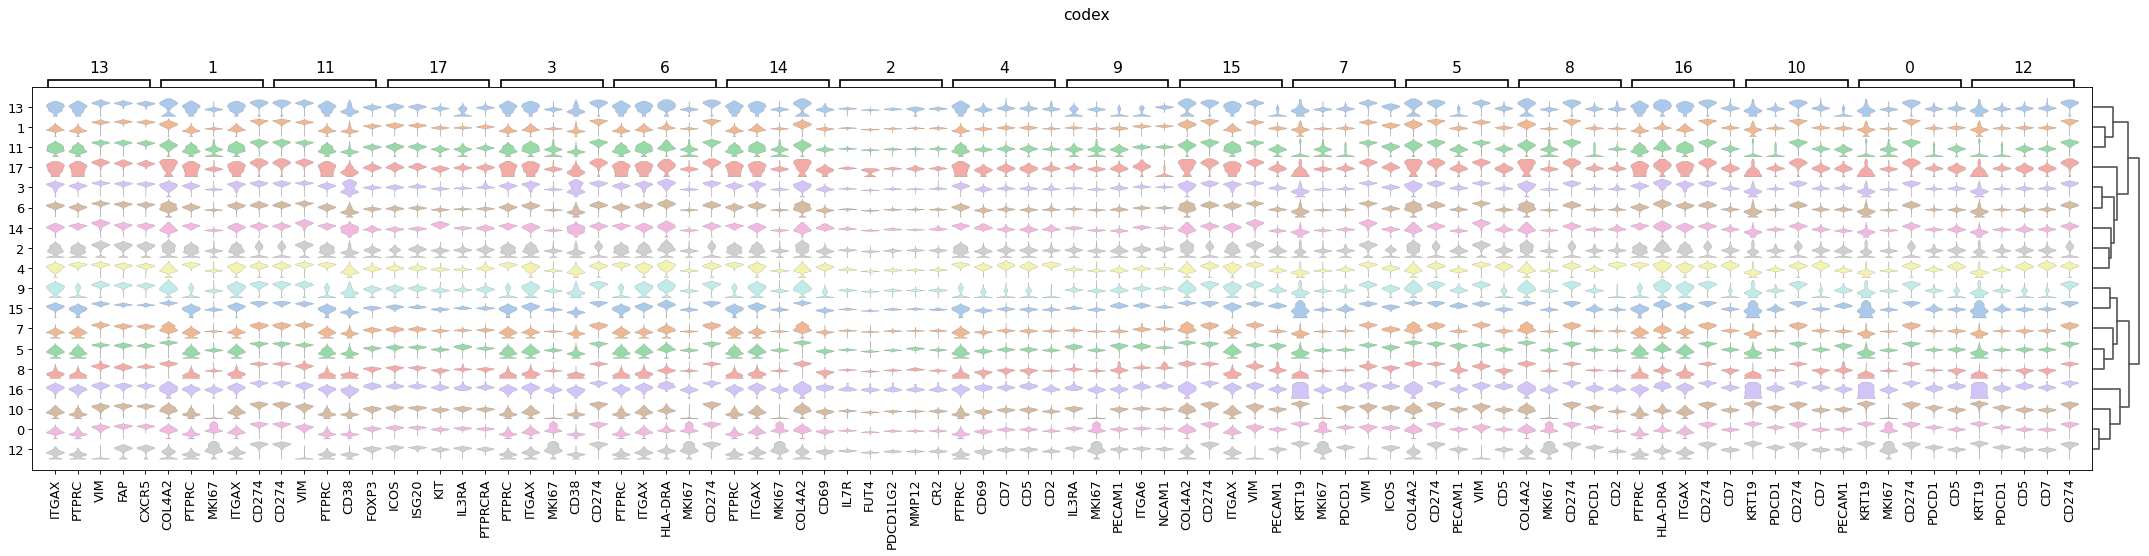

In [73]:
get_sub_markers(adatas,methods=[sc_method,*sm_methods],rest_thres=1)